In [65]:
# %pip install tf_keras_vis tflite-support-nightly
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
import PIL
import PIL.Image
from sklearn.preprocessing import MultiLabelBinarizer

# Create your dataset

1) Choose which classes you would like to add.

2) Create a dataset with your own photos

3) Separate your dataset into train and test subsets.

In [2]:
def create_dataframe_from_directories(path):
    data = []
    labels = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        label = label_dir.split("_")
        labels.append(label)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label[0], label[1]])
        
    return (pd.DataFrame(data, columns = ["path", "unit", "type"]), labels)

In [3]:
df_train, labels = create_dataframe_from_directories("dataset_train")
df_test, labels = create_dataframe_from_directories("dataset_test")
dataframe = pd.concat([df_train, df_test])

### Binarize labels

In [4]:
mlb = MultiLabelBinarizer()
labels_bin = mlb.fit_transform(labels)

for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label))

1. 1B
2. 2B
3. 3B
4. 4B
5. fille
6. gars
7. resp


### Display some images of your dataset

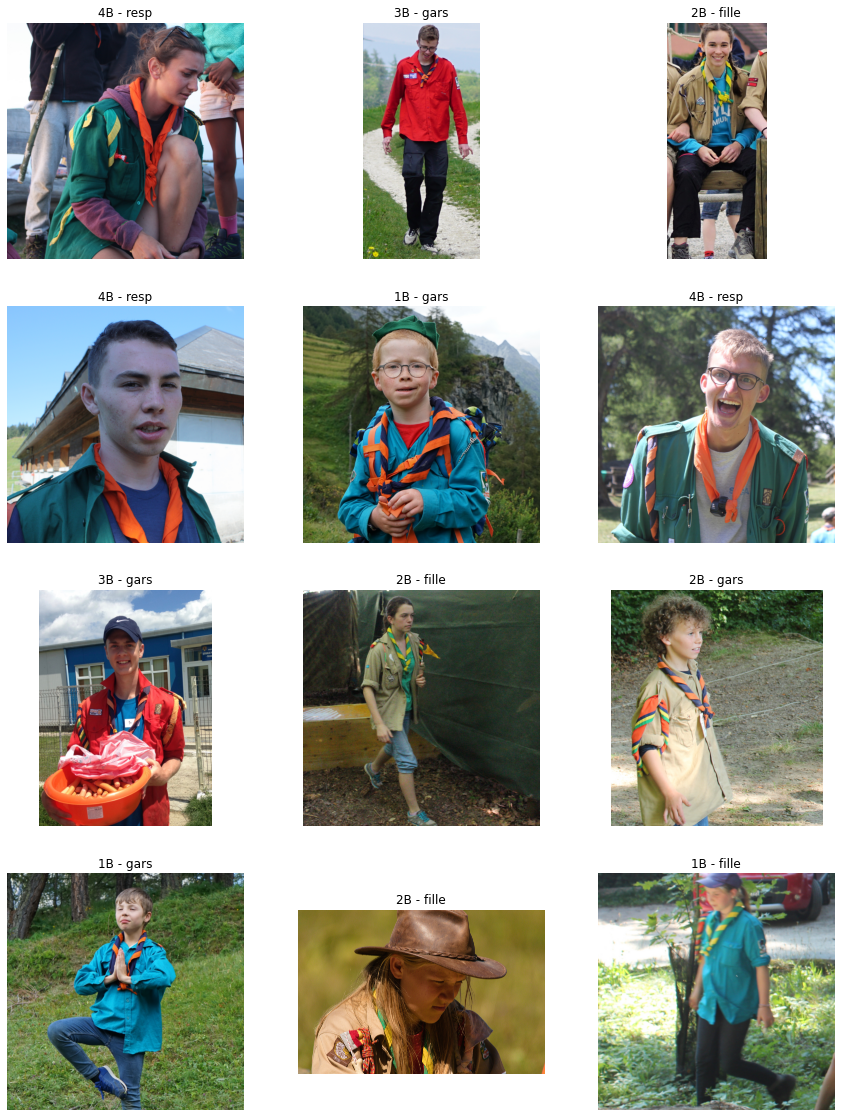

In [5]:
plt.figure(figsize=(15, 20))

i = 0
for _, rowdata in df_train.sample(frac=1).head(12).iterrows():
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(f'{rowdata.unit} - {rowdata.type}')
    plt.axis("off")
    i += 1

# Explore your dataset

In [6]:
def plot_bar(serie, label, color="tab:blue"):
   serie.value_counts().sort_index().plot.bar(title=f"Images per {label}", xlabel=label, ylabel="# of images", rot=45, color=color)
   print(f"{label}:\n{serie.value_counts().sort_index()}\n")

Unit:
1B    36
2B    33
3B    34
4B    34
Name: unit, dtype: int64

Types:
fille    50
gars     53
resp     34
Name: type, dtype: int64

Group:
1B - fille    17
1B - gars     19
2B - fille    18
2B - gars     15
3B - fille    15
3B - gars     19
4B - resp     34
dtype: int64



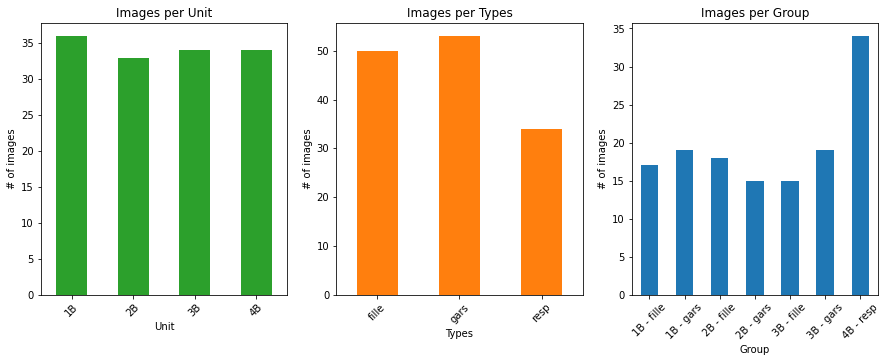

In [7]:
units = df_train.unit.value_counts().sort_index()
types = df_train.type.value_counts()
unit_types = df_train.groupby(["unit", "type"]).size()



plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1)
plot_bar(serie=df_train.unit, label="Unit", color="tab:green")
ax = plt.subplot(1, 3, 2)
plot_bar(serie=df_train.type, label="Types", color="tab:orange")
ax = plt.subplot(1, 3, 3)
plot_bar(df_train["unit"] + " - " + df_train["type"], "Group")

# Preprocessing steps

In [92]:
from tensorflow.keras.layers import (
    Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomWidth, RandomHeight, RandomContrast
)

from tensorflow.keras import Sequential
from tensorflow import keras

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH),#, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    RandomRotation(0.1, fill_mode="nearest"),
    RandomZoom(0.05),
    RandomContrast(0.15)
    ])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))
    
    return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img, training=True) for img in images
    ])

def augment_batch_images(images, labels, rate):
   aug_images = augment_images(images)
   aug_labels = labels
   for i in range(1, rate):
      new_images = augment_images(images)
      aug_images = np.concatenate([aug_images, new_images])
      aug_labels = np.concatenate([aug_labels, labels])
   return aug_images, aug_labels

**TODO**: plot examples of preprocessed and augmented images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


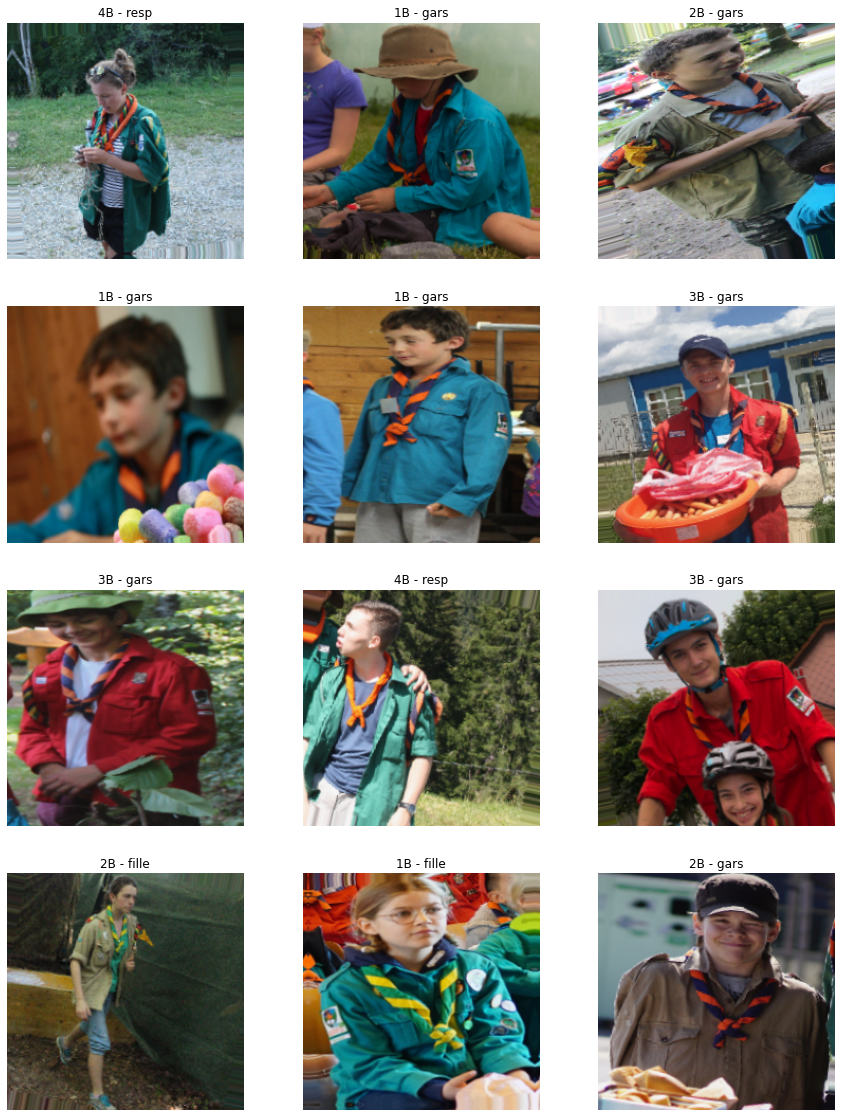

In [88]:
plt.figure(figsize=(15, 20))

i = 0
for _, rowdata in df_train.sample(frac=1).head(12).iterrows():
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(augment_images([open_image(rowdata.path)])[0])
    plt.title(f'{rowdata.unit} - {rowdata.type}')
    plt.axis("off")
    i += 1

## Define model

In [95]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    BatchNormalization,
    Dropout
)

def get_model(classes, finalActivation):
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    
    layers = base_model.output

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on 
        GlobalAveragePooling2D(), 
        Dense(128, activation="relu"),
        Dropout(0.25),
        Dense(256, activation="relu"),
        Dropout(0.25),
        Dense(512, activation="relu"),
        Dropout(0.25),
        Dense(classes, activation=finalActivation)
    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    total_layers = len(model.layers)  
    for i in range(total_layers):
       if i < total_layers - len(added_layers):
          model.layers[i].trainable = False
    
    model.compile(
      optimizer = RMSprop(),
      loss = BinaryCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [ ]:
#get_model().summary()

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time 

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

shuffled_dataset = dataframe.sample(frac=1).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['unit'].to_numpy()
dataset_labels = np.c_[dataset_labels, shuffled_dataset['type'].to_numpy()]

print("Split dataset")
total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=42
)

total_train_labels = mlb.transform(total_train_labels)
test_labels = mlb.transform(test_labels)

NB_EPOCHS = 10
AUGMENTATION_RATE = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Train model")

## TMP ##
# tmp_path = total_train_paths
# tmp_labels = total_train_labels
# total_train_paths = test_paths
# total_train_labels = test_labels
# test_paths = tmp_path
# test_labels = tmp_labels
## TMP ##

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    print("- Open images")
    train_images = open_images(total_train_paths[train_index])    
    train_labels = total_train_labels[train_index]
    
    val_images = open_images(total_train_paths[val_index])
    val_labels = total_train_labels[val_index]
    
    print("- Augment images")
    augmented_images, augmented_labels = augment_batch_images(train_images, train_labels, AUGMENTATION_RATE)
    print(f"- Reset model with {len(augmented_images)} images and {len(augmented_labels)} labels")
    model = get_model(len(mlb.classes_), "sigmoid") # We reinitialize the model

   #  print(augmented_images)
   #  print(augmented_labels)

    
    history = model.fit(
        x=augmented_images,
        y=augmented_labels,
        batch_size=32,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

Split dataset
Train model
- Open images
- Augment images
- Reset model with 2080 images and 2080 labels
Epoch 1/10


2022-06-10 15:56:52.918672: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1252392960 exceeds 10% of free system memory.


65/65 [==============================] - 150s 2s/step - loss: 0.1712 - acc: 0.4495 - val_loss: 4.4570 - val_acc: 0.3333
Epoch 2/10
65/65 [==============================] - 124s 2s/step - loss: 0.0429 - acc: 0.5418 - val_loss: 4.0293 - val_acc: 0.2222
Epoch 3/10
65/65 [==============================] - 114s 2s/step - loss: 0.0351 - acc: 0.4870 - val_loss: 3.1805 - val_acc: 0.4074
Epoch 4/10
65/65 [==============================] - 117s 2s/step - loss: 0.0086 - acc: 0.5582 - val_loss: 5.5269 - val_acc: 0.2222
Epoch 5/10
65/65 [==============================] - 104s 2s/step - loss: 0.0269 - acc: 0.5952 - val_loss: 5.4282 - val_acc: 0.1111
Epoch 6/10
65/65 [==============================] - 129s 2s/step - loss: 0.0096 - acc: 0.5043 - val_loss: 4.1870 - val_acc: 0.2963
Epoch 7/10
65/65 [==============================] - 126s 2s/step - loss: 0.0140 - acc: 0.5245 - val_loss: 4.0652 - val_acc: 0.4444
Epoch 8/10
65/65 [==============================] - 122s 2s/step - loss: 0.0086 - acc: 0.5822 

2022-06-10 16:20:04.162339: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1264435200 exceeds 10% of free system memory.


66/66 [==============================] - 136s 2s/step - loss: 0.1738 - acc: 0.4300 - val_loss: 6.5455 - val_acc: 0.0769
Epoch 2/10
66/66 [==============================] - 96s 1s/step - loss: 0.0330 - acc: 0.5071 - val_loss: 6.8578 - val_acc: 0.1538
Epoch 3/10
66/66 [==============================] - 103s 2s/step - loss: 0.0330 - acc: 0.4648 - val_loss: 4.3673 - val_acc: 0.3462
Epoch 4/10
66/66 [==============================] - 84s 1s/step - loss: 0.0250 - acc: 0.4424 - val_loss: 7.2881 - val_acc: 0.1923
Epoch 5/10
31/66 [=============>................] - ETA: 41s - loss: 0.0142 - acc: 0.4738

KeyboardInterrupt: 

# Results

In [41]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()

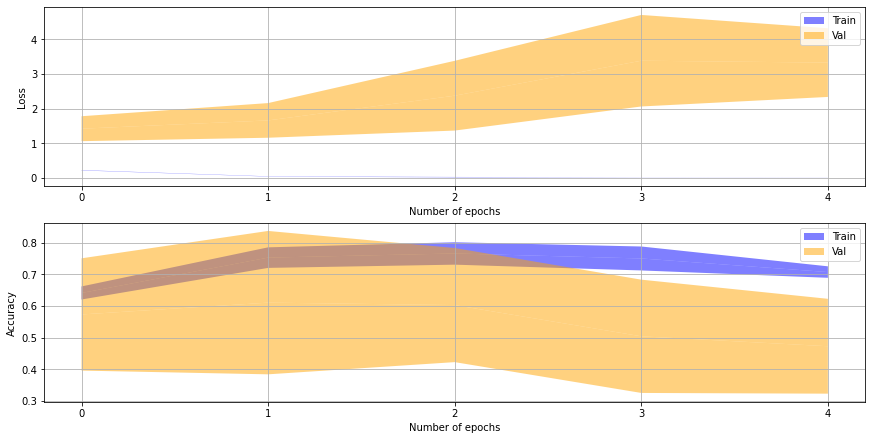

In [42]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

In [ ]:
# First retrain model on all the training data
train_images = open_images(total_train_paths)    
train_labels = total_train_labels

model = get_model(len(mlb.classes_), "sigmoid") # We reinitialize the model

history = model.fit(
    x=augment_images(train_images),
    y=train_labels,
    batch_size=32,
    epochs=NB_EPOCHS,
)

In [ ]:
# Empty a bit the memory
import gc

del train_images
del train_labels
gc.collect()

In [ ]:
import sklearn.metrics as me

test_images = open_images(test_paths)    

pred = model.predict(test_images)
pred = np.argmax(pred, axis=-1)

test_confusion_matrix = me.confusion_matrix(test_labels, pred, labels=np.arange(len(mlb.classes_)))

In [ ]:
confusion_matrix_display = me.ConfusionMatrixDisplay(
    confusion_matrix=test_confusion_matrix,
    display_labels=QUERIES,
)

confusion_matrix_display.plot(xticks_rotation='vertical')
plt.show()

### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 10

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
    
    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)    
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

**TODO**: try to determine what caused the misclassifcations and what you can do about it